<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Decision Tree   
<font color=black size=4>
    Hamidreza Yaghoubi 
    <br><br>
<font size=4>
   **Name**:MohammadMehdi Zare <br>
   **Student ID**:98100431 <br> <br>
<br><br>
<font size=4>
In this homework, we are going to implement the Classification Decision Tree. Keep in mind to complete all of the following questions and write your own codes in the TODO cells.

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 2: Classification Decision Tree (100 points)
We will implement a Classification Decision Tree from scratch in the following problem. Then we will use our model to predict malignant and benign breast cancer. For this purpose, we will use the breast_cancer.csv dataset which you can find more details about it <a href="https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset"><font face="Roboto">here</font></a>.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import log
import seaborn as sns
import random

<font face="Times New Roman" size=4><div dir=ltr>
## Classification Decision Tree Class (60 points)
In this section, you only need to fill TODO parts. You can find the logic and formula in both course slides and the web, but fill it out on your own. 

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        if self.value is not None:
            return True
        return False

In [3]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def is_splitting_finished(self, depth, num_class_labels, num_samples):
         if (depth == self.max_depth or num_samples <= self.min_samples_split or num_class_labels == 1) :
            return True
            return False

    def split(self, X, y, feature, threshold):
        left_indexes = X[feature] <= threshold
        right_indexes = -left_indexes
        X_left = X[left_indexes]
        y_left = y[left_indexes]
        X_right = X[right_indexes]
        y_right = y[right_indexes]

        return X_left, X_right, y_left, y_right

    def entropy(self, y):
        p = len(y[y.diagnosis == 1]) / len(y)
        if p == 1 or p == 0:
            return 0
        return -p * log(p, 2) - (1 - p) * log(1 - p, 2)


    def information_gain(self, X, y, feature, threshold):
        X_left, X_right, y_left, y_right = self.split(X, y, feature, threshold)
        H_y = self.entropy(y)
        p = len(X[X[feature] >= threshold]) / len(X)
        
        l=0
        r=0
        if len(y_left) != 0:
            l=(len(y_left)/len(y))*self.entropy(y_left)
        else:
            return 0
        if len(y_right) != 0:
            r=(len(y_right)/len(y))*self.entropy(y_right)
        else:
            return 0
        H_y_given_x = r+l
        return H_y - H_y_given_x

    
    
    def best_split(self, X, y):
        features = list(X.columns.values)
        random.shuffle(features)
        best_information_gain = 0
        best_feature = None
        best_threshold = None
        for feature in features:
            thresholds = list(set(list(X[feature])))
            for threshold in thresholds:
                info_gain = self.information_gain(X, y, feature, threshold)
                if info_gain >= best_information_gain:
                    best_information_gain = info_gain
                    best_feature = feature
                    best_threshold = threshold
        return best_feature, best_threshold


    def build_tree(self, X, y, depth=0):
        if self.is_splitting_finished(depth, len(X.columns), len(X)):
            return None

        best_feature, best_threshold = self.best_split(X, y)
        X_left, X_right, y_left, y_right = self.split(X, y, best_feature, best_threshold)

        left_node = self.build_tree(X_left, y_left, depth=depth + 1)
        right_node = self.build_tree(X_right, y_right, depth=depth + 1)

        value = None
        if left_node is None or right_node is None:
            true_value = len(y[y['diagnosis'] == 1])
            false_value = len(y[y['diagnosis'] == 0])
            if true_value >= false_value:
                value = 1
            else:
                value = 0

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node, value=value)

    def fit(self, X, y):
        self.root = self.build_tree(X, y)

    def predict(self, X):
        tree = self.root
        predicted_value = []
        for index in list(X.index):
            data = X.loc[index]
            current_tree = tree
            for depth in range(self.max_depth):
                if Node.is_leaf(current_tree):
                    predicted_value.append(current_tree.value)
                    break
                feature = current_tree.feature
                threshold = current_tree.threshold
                if data[feature] <= threshold:
                    current_tree = current_tree.left
                if data[feature] > threshold:
                    current_tree = current_tree.right

        return predicted_value

<font face="Times New Roman" size=4><div dir=ltr>
## Data Prepration (20 points)
In this section, you must perform a good EDA for data. Then split it into train and validation data. We will then use the validation data to find the best model hyperparameters.  

In [4]:
breast_cancer_pdf = pd.read_csv("breast_cancer.csv")

In [5]:
breast_cancer_pdf.describe()



,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [6]:
breast_cancer_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [7]:
breast_cancer_pdf.duplicated().sum() # 0 

0

In [8]:

breast_cancer_pdf.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

<AxesSubplot:>

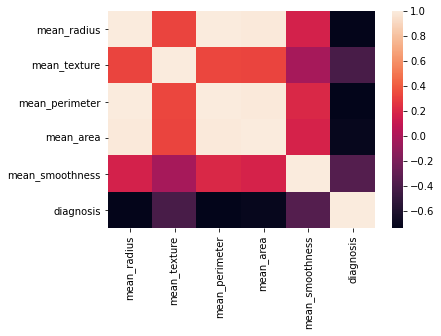

In [9]:
sns.heatmap(breast_cancer_pdf.corr())

In [10]:

breast_cancer_pdf.corr()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
mean_radius,1.000000,0.323782,0.997855,0.987357,0.170581,-0.730029
mean_texture,0.323782,1.000000,0.329533,0.321086,-0.023389,-0.415185
mean_perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,-0.742636
mean_area,0.987357,0.321086,0.986507,1.000000,0.177028,-0.708984
mean_smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,-0.358560
diagnosis,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,1.000000


In [11]:

X = breast_cancer_pdf.drop(['diagnosis'], axis=1)

y = breast_cancer_pdf[['diagnosis']]

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.70, random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
## Training And Tuning Hyperparameters (20 points)
In this section, you only need to find the best hyperparameters for your model. You can test different values and permutations of hyperparameters by adding them to the lists below. Your model must have at least accuracy=0.85 on validation data.

In [19]:
max_depths = [2,3,4,5,6,7,8,9,10,11,12]
min_samples_splits = [1,2,3,4,5,6,7,8,9,10]

In [20]:
best_max_depth = None
best_min_samples_split = None
best_accuracy = 0
best_model = None
for max_depth in max_depths:
    for min_samples_split in min_samples_splits:
        clf = DecisionTree(max_depth, min_samples_split)
        clf.fit(x_train, y_train)
        y_val_pred = clf.predict(x_val)
        y_train_pred = clf.predict(x_train)
        accuracy = accuracy_score(y_val_pred, y_val)
        train_accuracy = accuracy_score(y_train_pred, y_train)
        print(f"accuracy of training set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={train_accuracy}")
        print(f"accuracy of validation set for [min_samples_splits={min_samples_split}-max_depths={max_depth}] ={accuracy}")
        print("------------------------------------------------")
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split
            best_model = clf
        
print("best_accuracy : ",best_accuracy, "  best_max_depth: ",best_max_depth,"     best_min_samples_split: ",best_min_samples_split)

accuracy of training set for [min_samples_splits=1-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=1-max_depths=2] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=2-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=2-max_depths=2] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=3-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=3-max_depths=2] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=4-max_depths=2] =0.8705882352941177
accuracy of validation set for [min_samples_splits=4-max_depths=2] =0.8771929824561403
------------------------------------------------
accuracy of training set for [min_samples_splits=5-max_depths=2] =0.8705882352941177
accuracy of validation set for 

accuracy of training set for [min_samples_splits=9-max_depths=5] =0.888235294117647
accuracy of validation set for [min_samples_splits=9-max_depths=5] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=10-max_depths=5] =0.888235294117647
accuracy of validation set for [min_samples_splits=10-max_depths=5] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=1-max_depths=6] =0.9588235294117647
accuracy of validation set for [min_samples_splits=1-max_depths=6] =0.9223057644110275
------------------------------------------------
accuracy of training set for [min_samples_splits=2-max_depths=6] =0.9470588235294117
accuracy of validation set for [min_samples_splits=2-max_depths=6] =0.9223057644110275
------------------------------------------------
accuracy of training set for [min_samples_splits=3-max_depths=6] =0.9294117647058824
accuracy of validation set for 

accuracy of training set for [min_samples_splits=7-max_depths=9] =0.888235294117647
accuracy of validation set for [min_samples_splits=7-max_depths=9] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=8-max_depths=9] =0.888235294117647
accuracy of validation set for [min_samples_splits=8-max_depths=9] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=9-max_depths=9] =0.888235294117647
accuracy of validation set for [min_samples_splits=9-max_depths=9] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=10-max_depths=9] =0.888235294117647
accuracy of validation set for [min_samples_splits=10-max_depths=9] =0.8421052631578947
------------------------------------------------
accuracy of training set for [min_samples_splits=1-max_depths=10] =0.9764705882352941
accuracy of validation set for [